In [14]:
import numpy as np
import megengine as mge
import megengine.module as M
import megengine.functional as F
from megengine.utils.module_stats import module_stats
from functools import partial
import math

class D2SE_CNN(M.Module):
    def __init__(self):
        super(D2SE_CNN,self).__init__()
        #self.lamb = lambda x:( x + M.init.fill_(x,1e-7))
        self.Conv_BN_ReLU1 = M.Sequential(
            M.Conv2d(64,64,3,dilation = 1,padding = 1,stride = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU()
        )
        self.Conv_BN_ReLU2 = M.Sequential(
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU()
        )
        self.Conv_BN_ReLU3 = M.Sequential(
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU()
        )
        self.Conv_BN_ReLU = M.Sequential(
            M.Conv2d(64,64,3,dilation = 1,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 2,padding = 2),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 2,padding = 2),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 2,padding = 2),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 3,padding = 3),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 3,padding = 3),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 2,padding = 2),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 2,padding = 2),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 2,padding = 2),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 1,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 1,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 1,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU(),
            M.Conv2d(64,64,3,dilation = 1,padding = 1),
            M.BatchNorm2d(64),
            M.ReLU())
        self.dia = M.Sequential(
            M.Conv2d(1,4,3,dilation = 65,padding = 1)
           
        )
        self.Conv_ReLU_L1 = M.Sequential(
            M.Conv2d(4,64,3,padding = 1),
            M.ReLU()
        )
        self.Conv_ReLU_L8 = M.Sequential(
            M.Conv2d(64,4,3,padding = 1)
        )
        self.ConvTrans = M.ConvTranspose2d(4,4,4, stride = 2 , padding = 1)
        self.proj = M.Conv2d(1,1,5,padding = 2,stride = 1)
        self.avg_pool = M.AdaptiveAvgPool2d(1)
        self.fc = M.Sequential(
            M.Linear(64, 4, bias=False),
            M.ReLU(),
            M.Linear(4, 64, bias=False),
            M.Sigmoid()
        )
        self.apply(self._init_weights)
    #初始化各层参数
    def _init_weights(self, m):
            if isinstance(m, M.Conv2d):
                # print("Conv2d")
                fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                fan_out //= m.groups
                M.init.normal_(m.weight, 0, math.sqrt(2.0 / fan_out))
                # M.init.msra_normal_(m.weight,mode='fan_in')
                if m.bias is not None:
                    M.init.zeros_(m.bias)
            if isinstance(m, M.BatchNorm2d):
                # print("Batch")
                M.init.msra_normal_(m.weight, mode='fan_in')
                if m.bias is not None:
                    M.init.zeros_(m.bias)
            if isinstance(m, M.LayerNorm):
                # print("layerNorm")
                M.init.zeros_(m.bias)
                M.init.ones_(m.weight)
            if isinstance(m, M.Linear):
                # print("M.linear")
                M.init.normal_(m.weight, std=.02)
                if isinstance(m, M.Linear) and m.bias is not None:
                    M.init.zeros_(m.bias)
        
    def forward(self, x):
        n, c, h, w = x.shape
        #降采样
        x = x.reshape(n, c, h // 2, 2, w // 2, 2).transpose(0, 1, 3, 5, 2, 4)
        x = x.reshape(n, c * 4, h // 2, w // 2)
        x = self.Conv_ReLU_L1(x)
        #SE 通道注意力
        b, c2, _, _ = x.shape
        y = F.reshape(self.avg_pool(x),(b,c2)) # squeeze操作
        y = F.reshape(self.fc(y),(b, c2, 1, 1)) # FC获取通道注意力权重，是具有全局信息的
        x = x * F.broadcast_to(y,(x.shape))# 注意力作用每一个通道上
        x = self.Conv_BN_ReLU1(x)
        b, c2, _, _ = x.shape
        y = F.reshape(self.avg_pool(x),(b,c2)) # squeeze操作
        y = F.reshape(self.fc(y),(b, c2, 1, 1)) # FC获取通道注意力权重，是具有全局信息的
        x = x * F.broadcast_to(y,(x.shape))# 注意力作用每一个通道上
        x = self.Conv_BN_ReLU2(x)
        b, c2, _, _ = x.shape
        y = F.reshape(self.avg_pool(x),(b,c2)) # squeeze操作
        y = F.reshape(self.fc(y),(b, c2, 1, 1)) # FC获取通道注意力权重，是具有全局信息的
        x = x * F.broadcast_to(y,(x.shape))# 注意力作用每一个通道上
        x = self.Conv_BN_ReLU3(x)
        # x = self.Conv_BN_ReLU(x)
        x = self.Conv_ReLU_L8(x)
        x = x.reshape(n, c, 2, 2, h // 2, w // 2).transpose(0, 1, 4, 2, 5, 3)
        x = x.reshape(n, c, h, w)

        return x

if __name__ == '__main__':
    model = D2SE_CNN()
    input_data = np.random.rand(1, 1, 256, 256).astype("float32")
    out = model(mge.Tensor(input_data))
    print(out.shape)
    total_stats, stats_details = module_stats(
        model,
        inputs=(input_data,),
        cal_params=True,
        cal_flops=False,
        logging_to_stdout=False,
    )
    print(total_stats)

18 12:45:18 summary
----------------  ----------
item              value
#params           54
total_param_dims  413.828 K
total_param_size  1.579 MiB
total_act_dims    24.183 M
total_act_size    92.252 MiB
----------------  ----------


(1, 1, 256, 256)
total_stats(param_size=1655312, param_dims=413828, flops=0, act_size=96732720, act_dims=24183180)


In [15]:
import megengine as mge
import megengine.data as data
from megengine.data.dataset import Dataset
from megengine.data.sampler import SequentialSampler
import cv2
import megengine.data.transform as T
import megengine.optimizer as optim
import megengine.autodiff as autodiff
import os
import matplotlib.pyplot as plt
import time
import copy

class SAR_Data(Dataset):
    def __init__(self, dataset_path, crop_size, training_set) -> None:
        self.dataset_path = dataset_path
        self.noisy_path = os.path.join(dataset_path, 'noise_0.8')
        self.clean_path = os.path.join(dataset_path, 'mask_gray')
        self.images_noisy_list = sorted(os.listdir(self.noisy_path))
        self.images_clean_list = sorted(os.listdir(self.clean_path))
        # print(self.images_clean_list)
        self.training_set = training_set
        self.crop = crop_size
        if training_set == "train":  # 60%
            self.images_noisy_list = self.images_noisy_list[0:int(0.6 * len(self.images_noisy_list))]
            if self.images_clean_list[0] == '.DS_Store':
                self.images_clean_list = self.images_clean_list[1:int(0.6 * len(self.images_clean_list)+1)]
            else:
                self.images_clean_list = self.images_clean_list[0:int(0.6 * len(self.images_clean_list))]
#             print(self.images_noisy_list)
#             print(self.images_clean_list)
        elif training_set == "val":  # 20% = 60%->80%
            self.images_noisy_list = self.images_noisy_list[int(0.6 * len(self.images_noisy_list)):int(0.8 * len(self.images_noisy_list))]
            if self.images_clean_list[0] == '.DS_Store':
                self.images_clean_list = self.images_clean_list[int(0.6 * len(self.images_clean_list)+1):int(0.8 * len(self.images_clean_list)+1)]
            else:
                self.images_clean_list = self.images_clean_list[int(0.6 * len(self.images_clean_list)):int(0.8 * len(self.images_clean_list))]
        elif training_set == "test":
            self.images_noisy_list = self.images_noisy_list[int(0.8 * len(self.images_noisy_list)):]
            if self.images_clean_list[0] == '.DS_Store':
                self.images_clean_list = self.images_clean_list[int(0.8 * len(self.images_clean_list)+1):]
            else:
                self.images_clean_list = self.images_clean_list[int(0.8 * len(self.images_clean_list)):]


    def __len__(self):
        return len(self.images_noisy_list)

    def __getitem__(self, idx) -> tuple :
        image_noisy_filename = os.path.join(self.noisy_path,self.images_noisy_list[idx])
        image_clean_filename = os.path.join(self.clean_path,self.images_clean_list[idx])
#         print(image_noisy_filename)
#         print(image_clean_filename)
        image = cv2.imread(image_noisy_filename,0)
        mask = cv2.imread(image_clean_filename,0)
        #取出的数据均是0-256，
#         image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#         mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, 2)
        mask = np.expand_dims(mask, 2)
        
#         print(image)
        image = T.Resize((int(self.crop * 1.25), int(self.crop * 1.25))).apply(image) 
        image = image.astype(np.float32) / 255
#         print(image)
        mask = T.Resize((int(self.crop * 1.25), int(self.crop * 1.25))).apply(mask) 
        mask = mask.astype(np.float32) / 255
        image,mask = T.CenterCrop((self.crop)).apply(image),T.CenterCrop((self.crop)).apply(mask)
        image = T.Normalize(mean=[0.456], std=[0.224]).apply(image)
        return image,mask

def show_loss(epoch_list,loss_list):
    plt.plot(epoch_list, loss_list)
    plt.title('Traning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def total_variation(image_in):
    tv_h = F.sum(F.abs(image_in[:, :-1] - image_in[:, 1:]))
    tv_w = F.sum(F.abs(image_in[:-1, :] - image_in[1:, :]))
    tv_loss = tv_h + tv_w
    return tv_loss

def TV_loss(im_batch, weight):
    TV_L = 0.0
    for tv_idx in range(len(im_batch)):
        TV_L = TV_L + total_variation(im_batch[tv_idx, 0, :, :])
    TV_L = TV_L / len(im_batch)
    return weight * TV_L

batch_size = 8
crop_size = 256

#这里是数据集文件夹的路径名

train_dataset = SAR_Data("workspace/datasets/NWPUVHR", crop_size, training_set="train") #里面是图片的tensor数据,(3,256,236)
train_sampler = data.RandomSampler(train_dataset,batch_size=batch_size)
train_dataloader = data.DataLoader(train_dataset,train_sampler,num_workers=15)

val_dataset = SAR_Data("workspace/datasets/NWPUVHR", crop_size, training_set="val")
val_sampler = data.RandomSampler(val_dataset,batch_size=batch_size)
val_dataloader = data.DataLoader(val_dataset,val_sampler,num_workers=15)

test_dataset = SAR_Data("workspace/datasets/NWPUVHR", crop_size, training_set="test")
test_sampler = SequentialSampler(test_dataset,batch_size=batch_size)
test_dataloader = data.DataLoader(test_dataset,test_sampler,num_workers=15)

model = D2SE_CNN()
model.load_state_dict(mge.load("IDCNN_0.8N.pth"))
criterion = F.nn.l1_loss
# criterion = F.nn.square_loss
learning_rate = 0.0002
weight_decay = 1e-5
gm = autodiff.GradManager().attach(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

print("Everything is OK")


Everything is OK


In [ ]:
model.load_state_dict(mge.load("IDCNN_1.0BSCR.pth"))


In [ ]:
def show_out(img_out):
    img_out = F.clip(img_out[0].transpose(1,2,0),0,1)
    plt.imshow(img_out,cmap=plt.get_cmap('gray'))
    plt.show()

since = time.time()
num_epochs = 201
best_loss =  0.006392
loss_list = []
epoch_list = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (img, mask) in train_dataloader:
#         img.shape (16, 1, 256, 256) 即训练的输入形状
        img = mge.Tensor(img).transpose(0,3,1,2)
        mask = mge.Tensor(mask).transpose(0,3,1,2)
        with gm:
            img_out = model(img)
#             print("img_out.shape",img_out.shape) #img_out.shape (16, 3, 256, 256)
#             print("mask.shape",mask.shape) #mask.shape (16, 3, 256, 256)
            loss = criterion(img_out,mask)
            loss = loss + TV_loss(img_out, 0.000005)
            gm.backward(loss)
            optimizer.step().clear_grad()
        running_loss += loss.item()
    if epoch % 10 == 0 and epoch:
        show_out(img_out)
    epoch_loss = running_loss / len(train_dataset)
    epoch_list.append(epoch)
    loss_list.append(epoch_loss)
    print('Epoch {}/{} ,Train Loss: {:.8f}'.format(epoch, num_epochs - 1, epoch_loss))
    if epoch % 20 == 0 and epoch != 0:
        model.eval()
        running_loss = 0
        for (img, mask) in val_dataloader:
            img = mge.Tensor(img).transpose(0, 3, 1, 2)
            mask = mge.Tensor(mask).transpose(0, 3, 1, 2)
            img_out = model(img)
            loss = criterion(img_out,mask)
#             loss = loss + TV_loss(img_out, 0.000005)
            running_loss += loss.item()
        epoch_loss = running_loss / len(val_dataset)
        print('Epoch {}/{} ,Val Loss (MSE): {:.8f}'.format(epoch, num_epochs - 1, epoch_loss))
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_epoch = epoch
            print("best_epoch: ", best_epoch, "best_epoch_loss: ", epoch_loss)
            fout = open('0.8NTva.pth', 'wb')
            mge.save(model.state_dict(), fout)
            fout.close()

In [ ]:
fout = open('IDCNN_1.0BSCRlast.pth', 'wb')
mge.save(model.state_pdict(), fout)
fout.close()

In [ ]:
time_elapsed = time.time() - since
show_loss(epoch_list,loss_list)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:6f}'.format(best_loss))


In [14]:
model.load_state_dict(mge.load("0.8NTva.pth"))
model.eval()

test Loss (MSE): 0.004538


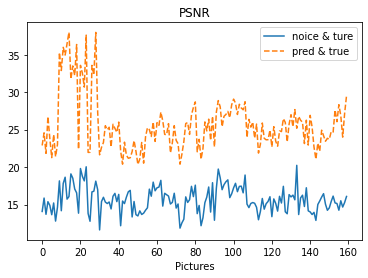

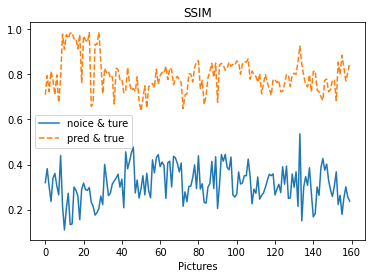

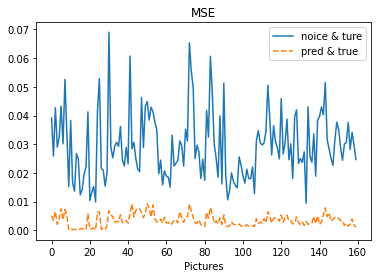

PSNR avg:  25.706861521824397
SSIM avg:  0.7967859551310539
MSE  avg:  0.0034941187629053067


In [16]:
from skimage.metrics import  peak_signal_noise_ratio,structural_similarity,mean_squared_error

def show_pic(img,img_out,mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,3,1)
    plt.imshow(img[0].transpose(1,2,0),cmap=plt.get_cmap('gray'))
    img_out = F.clip(img_out[0].transpose(1,2,0),0,1)
    plt.subplot(1,3,2)
    plt.imshow(img_out,cmap=plt.get_cmap('gray'))
#     plt.imshow(img_out)
    plt.subplot(1,3,3)
    plt.imshow(mask[0].transpose(1,2,0),cmap=plt.get_cmap('gray'))
#     plt.imshow(mask[0].transpose(1,2,0))
#     plt.savefig("Num5_comp2.jpg")
    plt.show()
    
PSNR_img,PSNR_imgout = [],[]
SSIM_img,SSIM_imgout = [],[]
MSE_img,MSE_imgout = [],[]
pic_list = np.arange(0,len(test_dataset),1)

def show_equality(pic_list,img_list,imgout_list,title):
    plt.plot(pic_list, img_list,label = "noice & ture")
    plt.plot(pic_list, imgout_list,linestyle = "--",label = "pred & true")
    plt.title(title)
    plt.xlabel('Pictures')
    plt.legend()
    plt.show()
def quality(img,img_out,mask,PSNR_img,SSIM_img,MSE_img,PSNR_imgout,SSIM_imgout,MSE_imgout):
    #shape (H,W,C)
    b ,_,_,_ = mask.shape
    for i in range(b):
        img_ = F.clip(img[i,:,:,:].transpose(1,2,0),0,1).numpy()
        img_out_ = F.clip(img_out[i,:,:,:].transpose(1,2,0),0,1).numpy()
        mask_ = F.clip(mask[i,:,:,:].transpose(1,2,0),0,1).numpy()
        mse = mean_squared_error(img_,mask_)
        ssim = structural_similarity(img_,mask_,channel_axis=2)
        psnr = peak_signal_noise_ratio(img_,mask_)
        PSNR_img.append(psnr)
        SSIM_img.append(ssim)
        MSE_img.append(mse)
        mse2 = mean_squared_error(img_out_,mask_)
        ssim2 = structural_similarity(img_out_,mask_,channel_axis=2)
        psnr2 = peak_signal_noise_ratio(img_out_,mask_)
        PSNR_imgout.append(psnr2)
        SSIM_imgout.append(ssim2)
        MSE_imgout.append(mse2)
    
    avg_psnr_pred = sum(i for i in PSNR_imgout) / len(PSNR_imgout)
    avg_ssim_pred = sum(i for i in SSIM_imgout) / len(SSIM_imgout)
    avg_mse_pred = sum(i for i in MSE_imgout) / len(MSE_imgout)
#     print("Batch PSNR avg : ",avg_psnr_pred)
#     print("Batch SSIM avg : ",avg_ssim_pred)
#     print("Batch MSE  avg : ",avg_mse_pred)

# model.load_state_dict(mge.load("best_epoch三.pth"))

model.eval()
running_loss = 0.0
for (img, mask) in test_dataloader:
    img = mge.Tensor(img).transpose(0, 3, 1, 2)
    mask = mge.Tensor(mask).transpose(0, 3, 1, 2)
    img_out = model(img)
    img = img*0.224+0.446
#     show_pic(img,img_out,mask)
    quality(img,img_out,mask,PSNR_img,SSIM_img,MSE_img,PSNR_imgout,SSIM_imgout,MSE_imgout)
    loss = criterion(img_out, mask)
    running_loss += loss.item()
epoch_loss = running_loss / len(test_dataset)
print('{} Loss (MSE): {:.6f}'.format("test", epoch_loss))
show_equality(pic_list,PSNR_img,PSNR_imgout,"PSNR")
show_equality(pic_list,SSIM_img,SSIM_imgout,"SSIM")
show_equality(pic_list,MSE_img,MSE_imgout,"MSE")

print("PSNR avg: ",sum(PSNR_imgout) / len(PSNR_imgout))
print("SSIM avg: ",sum(SSIM_imgout) / len(SSIM_imgout))
print("MSE  avg: ",sum(MSE_imgout) / len(MSE_imgout))

In [ ]:
import csv
def write_csv(epoch_list,loss_list,pic_list,PSNR_pred,SSIM_pred,MSE_pred):
    with open("0.8Na.csv", "w") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows([epoch_list,loss_list,pic_list,PSNR_pred,SSIM_pred,MSE_pred])
write_csv(epoch_list,loss_list,pic_list,PSNR_imgout,SSIM_imgout,MSE_imgout)


In [ ]:
from skimage.metrics import  peak_signal_noise_ratio,structural_similarity,mean_squared_error
from PIL import Image,ImageDraw
import megengine.data.transform as T

def show_chip_CvENL(img,title):
    var = F.var(img)
    mean = F.mean(img)
    Cv = var / mean 
    ENL = mean ** 2 / var ** 2 / img.shape[0]
#     print(title,"的变异系数Cv ： ", Cv.numpy(),end="  ")  # 变异系数越小越好
#     print(title,"的等效系数ENL： ", ENL.numpy())  # 等效系数越大越好
def show_crop():
    im = Image.open("workspace/Image/test_01.png")
    draw = ImageDraw.Draw(im) #实例化一个对象
    draw.line([(110,270), (150,270), (150, 310), (110, 310), (110, 270)], fill="yellow", width=5)
    draw.line([(270,110),(270,150),(310,150),(310,110),(270,110)], fill="yellow", width=5) #线的起点和终点，线宽
    im.show()
#     im.save("test1.png")


plt.figure(figsize=(30,30))
noise = cv2.imread("workspace/Image/test_01.png",0)

noise = np.expand_dims(noise,2)
noise = np.expand_dims(noise,0)

noise = noise.astype(np.float32) / 255
noise = mge.Tensor(noise).transpose(0,3,1,2)
noise = T.Normalize(mean=[0.456], std=[0.224]).apply(noise)

pred = model(noise)

# noise = noise*0.224+0.446
noise = noise[0][0]
pred = pred[0][0]
plt.imsave("test1.png",pred,cmap="gray")

show_crop()
plt.subplot(1,2,1)
plt.imshow(noise,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(pred,cmap="gray")
plt.show()

cropImg1 = pred[80:110, 45:80]  # 裁剪图像
show_chip_CvENL(cropImg1,"Region1")
cropImg2 = pred[110:150, 270:310]
show_chip_CvENL(cropImg2,"Region2")


In [ ]:
from skimage.metrics import  peak_signal_noise_ratio,structural_similarity,mean_squared_error
from PIL import Image,ImageDraw
def show_chip_CvENL(img,title):
    var = F.var(img)
    mean = F.mean(img)
    Cv = var / mean 
    ENL = mean ** 2 / var ** 2 / img.shape[0]
#     print(title,"的变异系数Cv ： ", Cv.numpy(),end="  ")  # 变异系数越小越好
#     print(title,"的等效系数ENL： ", ENL.numpy())  # 等效系数越大越好
def show_crop():
    im2 = Image.open("workspace/Image/test_02.png")
    draw = ImageDraw.Draw(im2)  # 实例化一个对象
    draw.line([(170,180), (170,230), (210,230), (210,180), (170,180)], fill="yellow", width=5)  # 线的起点和终点，线宽
    draw.line([(465,60), (465,100), (500,100), (500,60), (465,60)], fill="yellow", width=5)  # 线的起点和终点，线宽
    im2.show()
#     im2.save("test2.png")
    
plt.figure(figsize=(30,30))
noise = cv2.imread("workspace/Image/test_02.png",0)
noise = np.expand_dims(noise,2)
noise = np.expand_dims(noise,0)
noise = noise.astype(np.float32) / 255
noise = mge.Tensor(noise).transpose(0,3,1,2)
noise = T.Normalize(mean=[0.456], std=[0.224]).apply(noise)

pred = model(noise)
# noise = noise*0.224+0.446
noise = noise[0][0]
pred = pred[0][0]
plt.imsave("test2.png",pred,cmap="gray")
show_crop()
plt.subplot(1,2,1)
plt.imshow(noise,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(pred,cmap="gray")
plt.show()

cropImg1 = pred[80:110, 45:80]  # 裁剪图像
show_chip_CvENL(cropImg1,"Region1")
cropImg2 = pred[110:150, 270:310]
show_chip_CvENL(cropImg2,"Region2")